# Sentence similarity with NLU using BERT embeddings
![JohnSnowLabs](https://nlp.johnsnowlabs.com/assets/images/logo.png)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JohnSnowLabs/nlu/blob/master/examples/colab/component_examples/sentence_embeddings/sentence_similarirty_stack_overflow_questions.ipynb)

## What will we cover?

## 1. How to get sentence Bert, USE, Electra sentence embeddings using BERT
## 2. How to find N most similar sentences in a dataset for a given sentence in the dataset using BERT
## 3. How to calculate the similarity matrix and visualize it for a dataset using  BERT
## 4. How to find the N most similar sentences in a datset for a **new sentence** that does not exist in the data using BERT
## 5. How to find the N most similar sentences in a dataset for a new sentence using BERT, USE, Electra at the same time!




# 0.1 Install NLU and Java

In [ ]:
!wget https://setup.johnsnowlabs.com/nlu/colab.sh -O - | bash
  

import nlu

--2021-05-01 23:03:29--  https://raw.githubusercontent.com/JohnSnowLabs/nlu/master/scripts/colab_setup.sh
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1671 (1.6K) [text/plain]
Saving to: ‘STDOUT’

-                   100%[===================>]   1.63K  --.-KB/s    in 0s      

2021-05-01 23:03:29 (53.7 MB/s) - written to stdout [1671/1671]

Installing  NLU 3.0.0 with  PySpark 3.0.2 and Spark NLP 3.0.1 for Google Colab ...
     |████████████████████████████████| 204.8MB 67kB/s 
     |████████████████████████████████| 153kB 54.1MB/s 
     |████████████████████████████████| 204kB 23.9MB/s 
     |████████████████████████████████| 204kB 47.2MB/s 


# 0.2 Download sample dataset 60k Stack Overflow Questions with Quality Rating


https://www.kaggle.com/imoore/60k-stack-overflow-questions-with-quality-rate

In [ ]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Download the dataset 
! wget -N https://ckl-it.de/wp-content/uploads/2020/11/60kstackoverflow.csv -P /tmp
# Load dataset to Pandas
df = pd.read_csv('/tmp/60kstackoverflow.csv')
max_r = 5000
df = df.iloc[0:max_r]
df

--2021-05-01 23:05:27--  https://ckl-it.de/wp-content/uploads/2020/11/60kstackoverflow.csv
Resolving ckl-it.de (ckl-it.de)... 217.160.0.108, 2001:8d8:100f:f000::209
Connecting to ckl-it.de (ckl-it.de)|217.160.0.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 50356825 (48M) [text/csv]
Saving to: ‘/tmp/60kstackoverflow.csv’

60kstackoverflow.cs 100%[===================>]  48.02M  6.75MB/s    in 7.6s    

2021-05-01 23:05:35 (6.29 MB/s) - ‘/tmp/60kstackoverflow.csv’ saved [50356825/50356825]



,Id,Title,Body,Tags,CreationDate,Y
0,34552656,Java: Repeat Task Every Random Seconds,<p>I'm already familiar with repeating tasks e...,<java><repeat>,2016-01-01 00:21:59,LQ_CLOSE
1,34553034,Why are Java Optionals immutable?,<p>I'd like to understand why Java 8 Optionals...,<java><optional>,2016-01-01 02:03:20,HQ
2,34553174,Text Overlay Image with Darkened Opacity React...,<p>I am attempting to overlay a title over an ...,<javascript><image><overlay><react-native><opa...,2016-01-01 02:48:24,HQ
3,34553318,Why ternary operator in swift is so picky?,"<p>The question is very simple, but I just cou...",<swift><operators><whitespace><ternary-operato...,2016-01-01 03:30:17,HQ
4,34553755,hide/show fab with scale animation,<p>I'm using custom floatingactionmenu. I need...,<android><material-design><floating-action-but...,2016-01-01 05:21:48,HQ
...,...,...,...,...,...,...
4995,36742008,is it possible to use JavaScriptSpellCheck in ...,<p>I would like to perform Spell Checking on t...,<javascript><html><jsp>,2016-04-20 11:11:19,LQ_CLOSE
4996,36743857,"Map<String, Integer> foo - how do I get the va...",<p>I have a method:</p>\n\n<pre><code> public...,<java><dictionary><hashmap>,2016-04-20 12:29:50,LQ_CLOSE
4997,36744886,Facebook SDK iOS - User photos doesn't retriev...,<p>I am facing a weird bug with Facebook SDK. ...,<ios><objective-c><facebook><facebook-graph-ap...,2016-04-20 13:09:41,LQ_CLOSE
4998,36746382,Validate user input using seperate function,<p>How do I get this to not return 'brea outsi...,<python><python-3.x><python-3.5>,2016-04-20 14:07:03,LQ_CLOSE


# 1. Embed Sentences with Bert Sentence Embeddings  

We could either embed the Title or the question Body.

In [ ]:
pipe = nlu.load('embed_sentence.bert')
# pipe = nlu.load('en.embed_sentence.bert_large_cased') # if you have some time and RAM try a big BERT model!
predictions = pipe.predict(df.Title, output_level='document')
predictions

sent_small_bert_L2_128 download started this may take some time.
Approximate size to download 16.1 MB
[OK!]
sentence_detector_dl download started this may take some time.
Approximate size to download 354.6 KB
[OK!]


,document,sentence_embedding_bert
0,Java: Repeat Task Every Random Seconds,"[-2.009953498840332, 0.08406741172075272, -0.0..."
1,Why are Java Optionals immutable?,"[-0.9489684700965881, -0.04183836281299591, -0..."
2,Text Overlay Image with Darkened Opacity React...,"[-0.7274762392044067, -0.8136711716651917, -0...."
3,Why ternary operator in swift is so picky?,"[-1.0510447025299072, 0.16469576954841614, -0...."
4,hide/show fab with scale animation,"[-0.801064133644104, -0.08930190652608871, -0...."
...,...,...
4995,is it possible to use JavaScriptSpellCheck in ...,"[-0.28274181485176086, 0.9793228507041931, 0.2..."
4996,"Map<String, Integer> foo - how do I get the va...","[-0.7471789121627808, 0.14025633037090302, 0.1..."
4997,Facebook SDK iOS - User photos doesn't retriev...,"[0.2970831096172333, 0.5095561146736145, -0.35..."
4998,Validate user input using seperate function,"[-0.9171112775802612, 0.5364910960197449, -0.5..."


# 2.1 How to find N most similar sentences in a dataset for a given sentence in the dataset using BERT    
Sentences with small distances between their embeddings will be deemed as similar to each other. 

In [ ]:

## Calculate dinstance between all pairs of sentences in DF 
e_col = 'sentence_embedding_bert'

def get_sim_df_for_iloc(sent_iloc, predictions=predictions,e_col=e_col, pipe=pipe):
  # This function calculatse the distances for one sentences at  predictions[sent_iloc] to all other sentences in predictions using the embedding defined by e_col 
  # put embeddings in matrix
  embed_mat = np.array([x for x in predictions[e_col]])
  # calculate distance between every embedding pair
  sim_mat = cosine_similarity(embed_mat,embed_mat)
  print("Similarities for Sentence : " + df.iloc[sent_iloc].Title)
  # write sim scores to df
  df['sim_score'] = sim_mat[sent_iloc]
  return df 
sentence_to_compare=33
sim_df_for_one_sent = get_sim_df_for_iloc(sentence_to_compare,predictions,e_col)
sim_df_for_one_sent.sort_values('sim_score', ascending = False)

Similarities for Sentence : How to play gif in android from url?


,Id,Title,Body,Tags,CreationDate,Y,sim_score
33,34562879,How to play gif in android from url?,<p>I want to play animated gif from url in and...,<android><animated-gif>,2016-01-02 05:21:15,HQ,1.000000
2999,35734941,How to combine multiple find() in jquery?,<p>I have these two conditions:</p>\n\n<p>1) F...,<javascript><jquery>,2016-03-01 22:32:43,LQ_CLOSE,0.902185
3917,36146295,how to create a alert box in android alternati...,<p><strong>Create an alert box that show alter...,<java><android>,2016-03-22 04:49:09,LQ_CLOSE,0.901864
3971,36163803,How to get assets img url in Symfony controller,<p>I'm using assets in Symfony 2.7.10 and I wa...,<symfony><twig><assets>,2016-03-22 19:47:10,HQ,0.896660
2455,35506935,what is the URL for JetBrains IDE plug-in repo...,"<p>I thought this was a simple question, and s...",<plugins><intellij-idea><repository>,2016-02-19 13:50:04,HQ,0.891305
...,...,...,...,...,...,...,...
3326,35870607,background invalid property,<p>The page only accepts colors in the backgro...,<css><background-image>,2016-03-08 14:53:30,LQ_CLOSE,0.561228
447,34705628,Undefined variable,<p>I still get this error for some I guess stu...,<php><laravel><laravel-5>,2016-01-10 12:58:08,LQ_CLOSE,0.560557
181,34610787,Undefined index,<p>I get Undefined index: image error in this ...,<php><undefined-index>,2016-01-05 11:35:49,LQ_CLOSE,0.550355
4303,36280912,Calculating summations,"<p><a href=""http://i.stack.imgur.com/YkWea.png...",<algorithm><math>,2016-03-29 09:53:15,LQ_CLOSE,0.544262


# 2.2 Plotting function for plotting the distance between one sentence in the dataset and every other sentence

Similarities for Sentence : Java: Repeat Task Every Random Seconds


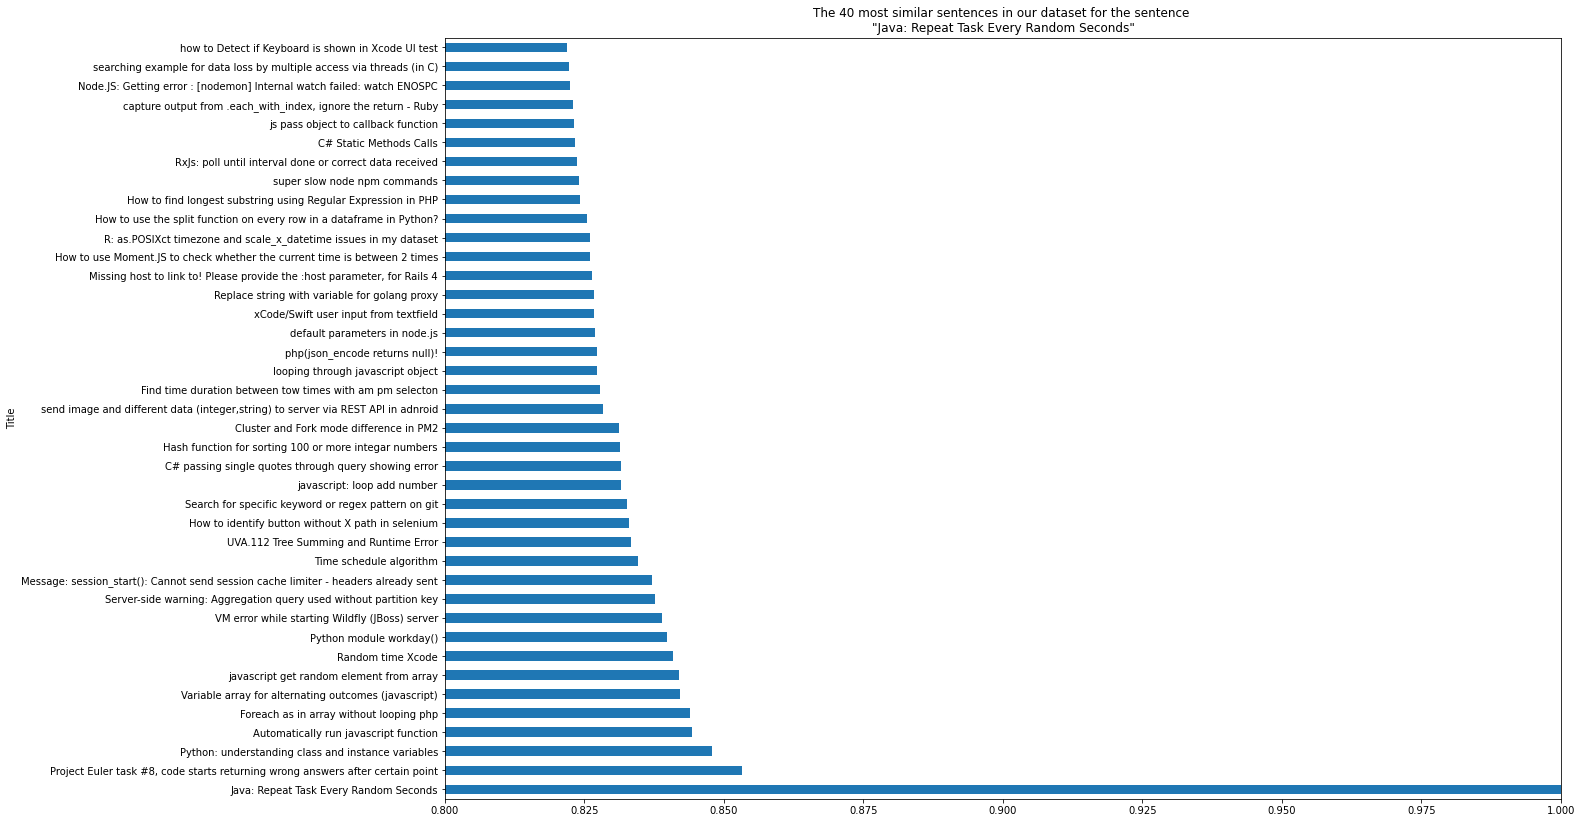

In [ ]:
def viz_sim_df_for_one_sent( sent_iloc=0, N = 40, sim_df_for_one_sent=sim_df_for_one_sent):
  # Plots the N most similar sentences in our dataframe for sentence at position sent_iloc
  sim_df_for_one_sent = get_sim_df_for_iloc(sent_iloc)
  
  sim_df_for_one_sent.index = sim_df_for_one_sent.Title
  sent = sim_df_for_one_sent.iloc[sent_iloc].Title
  ax = sim_df_for_one_sent.sort_values('sim_score', ascending = False).iloc[:N].sim_score.plot.barh(title=f'The {N} most similar sentences in our dataset for the sentence \n"{sent}"', figsize=(20,14))
  ax.set_xlim(0.8, 1)

# Just put in any number and get the plot for similarities of the sentence at df.iloc[i]
viz_sim_df_for_one_sent(0)

# 3.1  Calculate every similarity score between every sentence in the input dataframe pairwise and generate similarity matrix

In [ ]:
def get_sim_df_total( predictions,e_col, string_to_embed,pipe=pipe):
  # This function calculates the distances between every sentence pair. Creates for ever sentence a new column with the name equal to the sentence it comparse to 
  # put embeddings in matrix
  embed_mat = np.array([x for x in predictions[e_col]])
  # calculate distance between every embedding pair
  sim_mat = cosine_similarity(embed_mat,embed_mat)
  # for i,v in enumerate(sim_mat): predictions[str(i)+'_sim'] = sim_mat[i]
  for i,v in enumerate(sim_mat): 
    s = predictions.iloc[i].document
    predictions[s] = sim_mat[i]

  return predictions 

sim_matrix_df = get_sim_df_total(predictions,'sentence_embedding_bert', 'How to get started with Machine Learning and Python' )
sim_matrix_df

,document,sentence_embedding_bert,Java: Repeat Task Every Random Seconds,Why are Java Optionals immutable?,Text Overlay Image with Darkened Opacity React Native,Why ternary operator in swift is so picky?,hide/show fab with scale animation,Accessing pointer member of the structure using structure pointer,"How To Disable 2nd Saturday 4th Saturday ,Sunday And Holiday Date Using JQuery Calendar",Resizing containers in bootstrap,Changing Theme in Windows 10 UWP App Programmatically,TextBox Value Disappears VB6,MongoDB Failing to Start - ***aborting after fassert() failure,What's the best way to store text data?,ios/objective-c/xcode: Expand Label based on quantity of text using Storyboard,"output FILE ,is this a fault?",Pod install displaying error in cocoapods version 1.0.0.beta.1,Haskell Stack Ghci test-suite,Why does the reverse() function in the Swift standard library return ReverseRandomAccessCollection?,eb deploy does not update the code,How to create a function that returns a byte array in C++? Arduino project.,bluebird.js vs bluebird.core.js what is the difference?,Create a temporary directory in PowerShell?,how to make sure a file's integrity in C#,Stopwatch and ReadKey doesn't work properly,Vbscript email attachment,Can I throw from class init() in Swift with constant string loaded from file?,C# - Count a specific word in richTextBox1 and send the result to label1,Android: Create bigger Floating Action Button with bigger icon,Should I use the final modifier when declaring case classes?,I need to create an array with numbers given by the user,How do I make the Kotlin compiler treat warnings as errors?,c++ vector type function implemetation,Java and enum [Novice],Difference between uwsgi_pass and proxy_pass in Nginx?,How to play gif in android from url?,undefined reference to SIGN in C using GCC,What does the double backslash mean in a function parameter in Elixir?,Sending a positive octet of zero bits over a socket,any one can help me with this sql syntax error? what should i use near the select statement,...,Popup in android after i scan,Create XMl file in particular format in c#,How to select the last blcok element in a repeated html in webdriver,php session not working when redirecting in another page,Read numerical values from a file with lines of strings,Best way to achieve custom ui layout in Visual Studio (c#),im having this error,What's the name of an OSX-like list object in Java FX in Windows?,Are these statements equivalent?: import package vs from package import *,I want to print the most visited sites/urls in the browser.,Where i can learn about openstack and cloud computing,Why compilation fails?,Best merge or join function in r,Need Assistance Understanding ls -d command in linux,getting a number using regular expressions,what's wrong with this simple code,Python re.search Patterns,Why does this change to the makefile make the performance go up?,What is the difference between events and helpers?,Keep getting matching error in haskell when testing function,Getting Error I cannot ger it,expected primary expression before ']' token ...... line 10 column 21,Counting the number of elements associated with another value in R,email and mobilenumber validation same textbox html5 with button,How to encrypt with both the private key and public key,How to acess different date format in js,Float Exponent from user input,convert dollar into Indian rupee,Grovy ALM HpQC - How to fill ST_ACTUAL design step field,"i want to display All ""name"" values in array (underscore/js)",Is it possible to use the instance defined in managed C++ class in C#?,Auto Generate alphanumeric Unique Id with C# with sql server,insert into column data into new table,Add a security code to http get request,Error: unexpected '}',is it possible to use JavaScriptSpellCheck in jsp pages?,"Map<String, Integer> foo - how do I get the value of the integer - JAVA",Facebook SDK iOS - User photos doesn't retrieving in release build but works perfectly in Deb

#3.2 Plot heatmap of similarity Matrix for the first N sentences

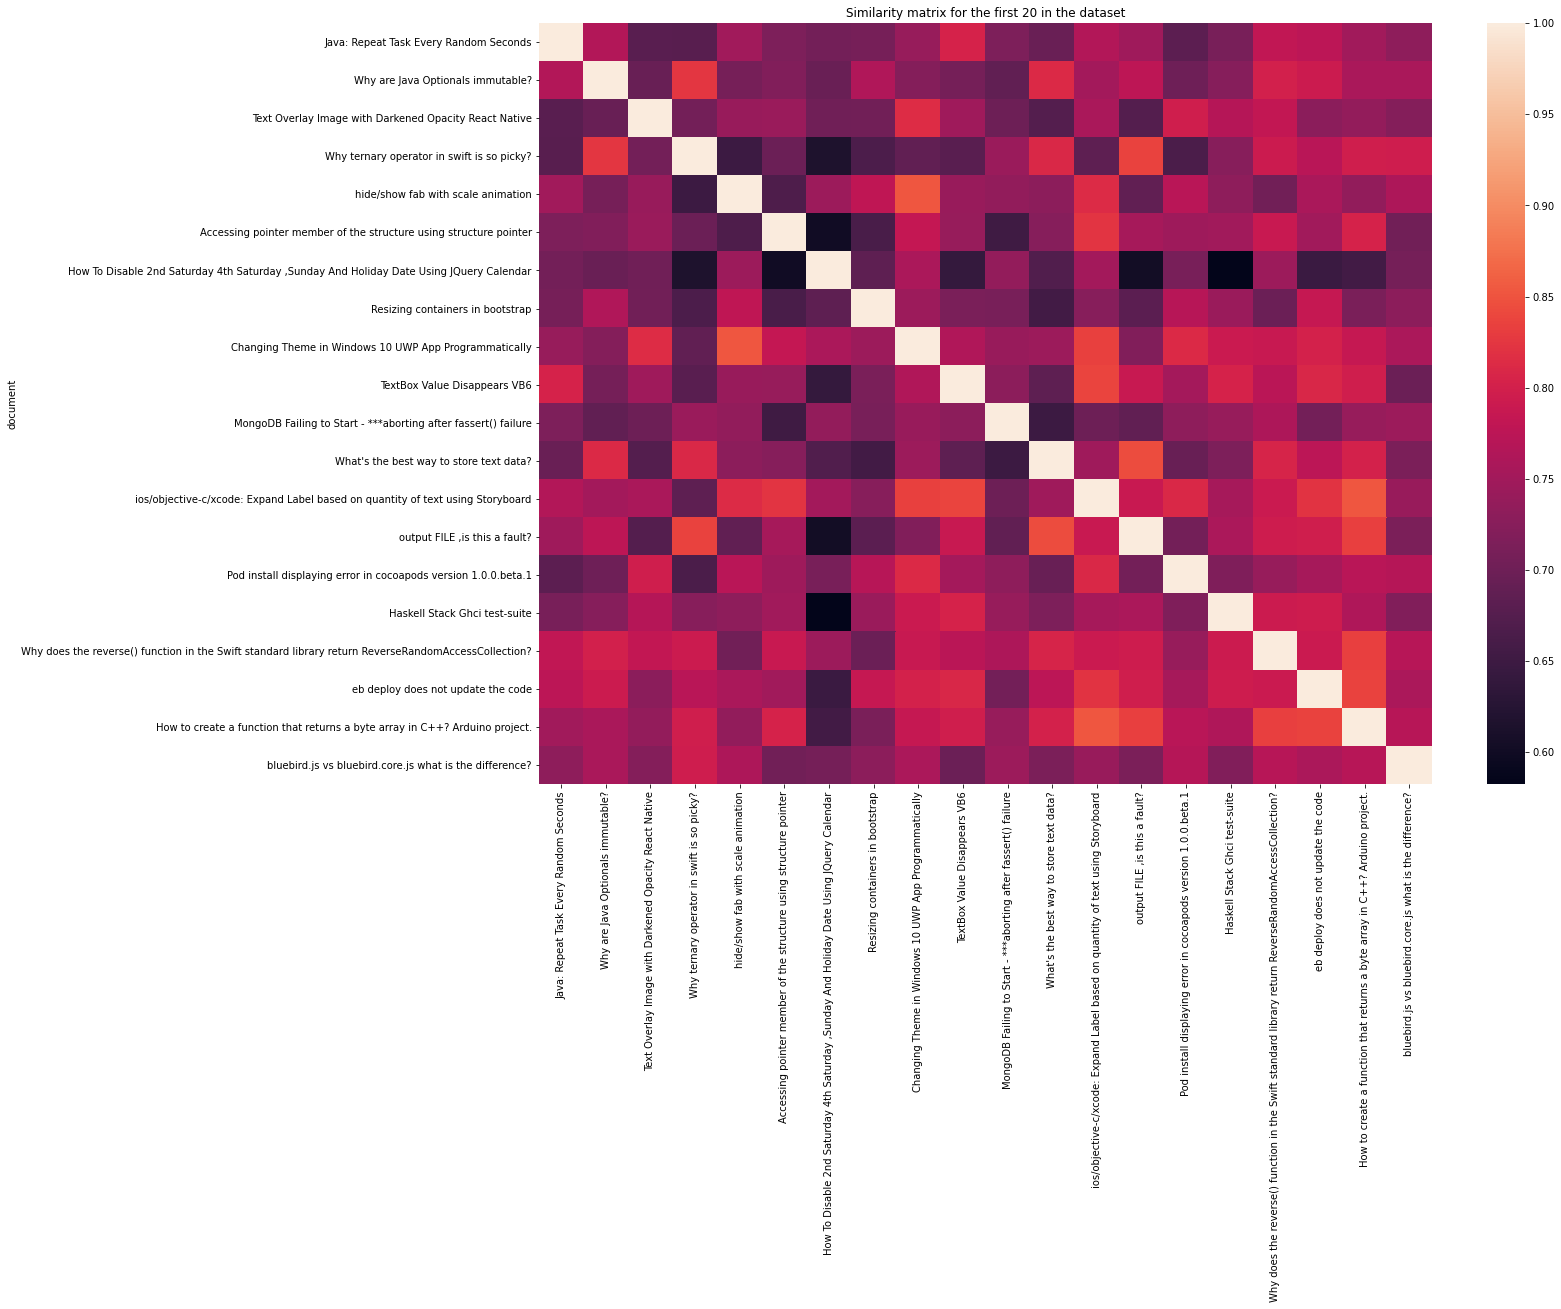

In [ ]:
non_sim_columns  = ['document','sentence_embedding_bert']

def viz_sim_matrix_first_n(num_sentences=20, sim_df = sim_matrix_df):
  # Plot heatmap for the first num_sentences
  fig, ax = plt.subplots(figsize=(20,14)) 
  sim_df.index = sim_df.document
  sim_columns = list(sim_df.columns)
  for b in non_sim_columns : sim_columns.remove(b)
  # sim_matrix_df[sim_columns]
  ax = sns.heatmap(sim_df.iloc[:num_sentences][sim_columns[:num_sentences]]) 

  ax.axes.set_title(f"Similarity matrix for the first {num_sentences} in the dataset",)

viz_sim_matrix_first_n()

#3.3 Plot heatmap of similarity Matrix for the sentences between starT_iloc and end_iloc 

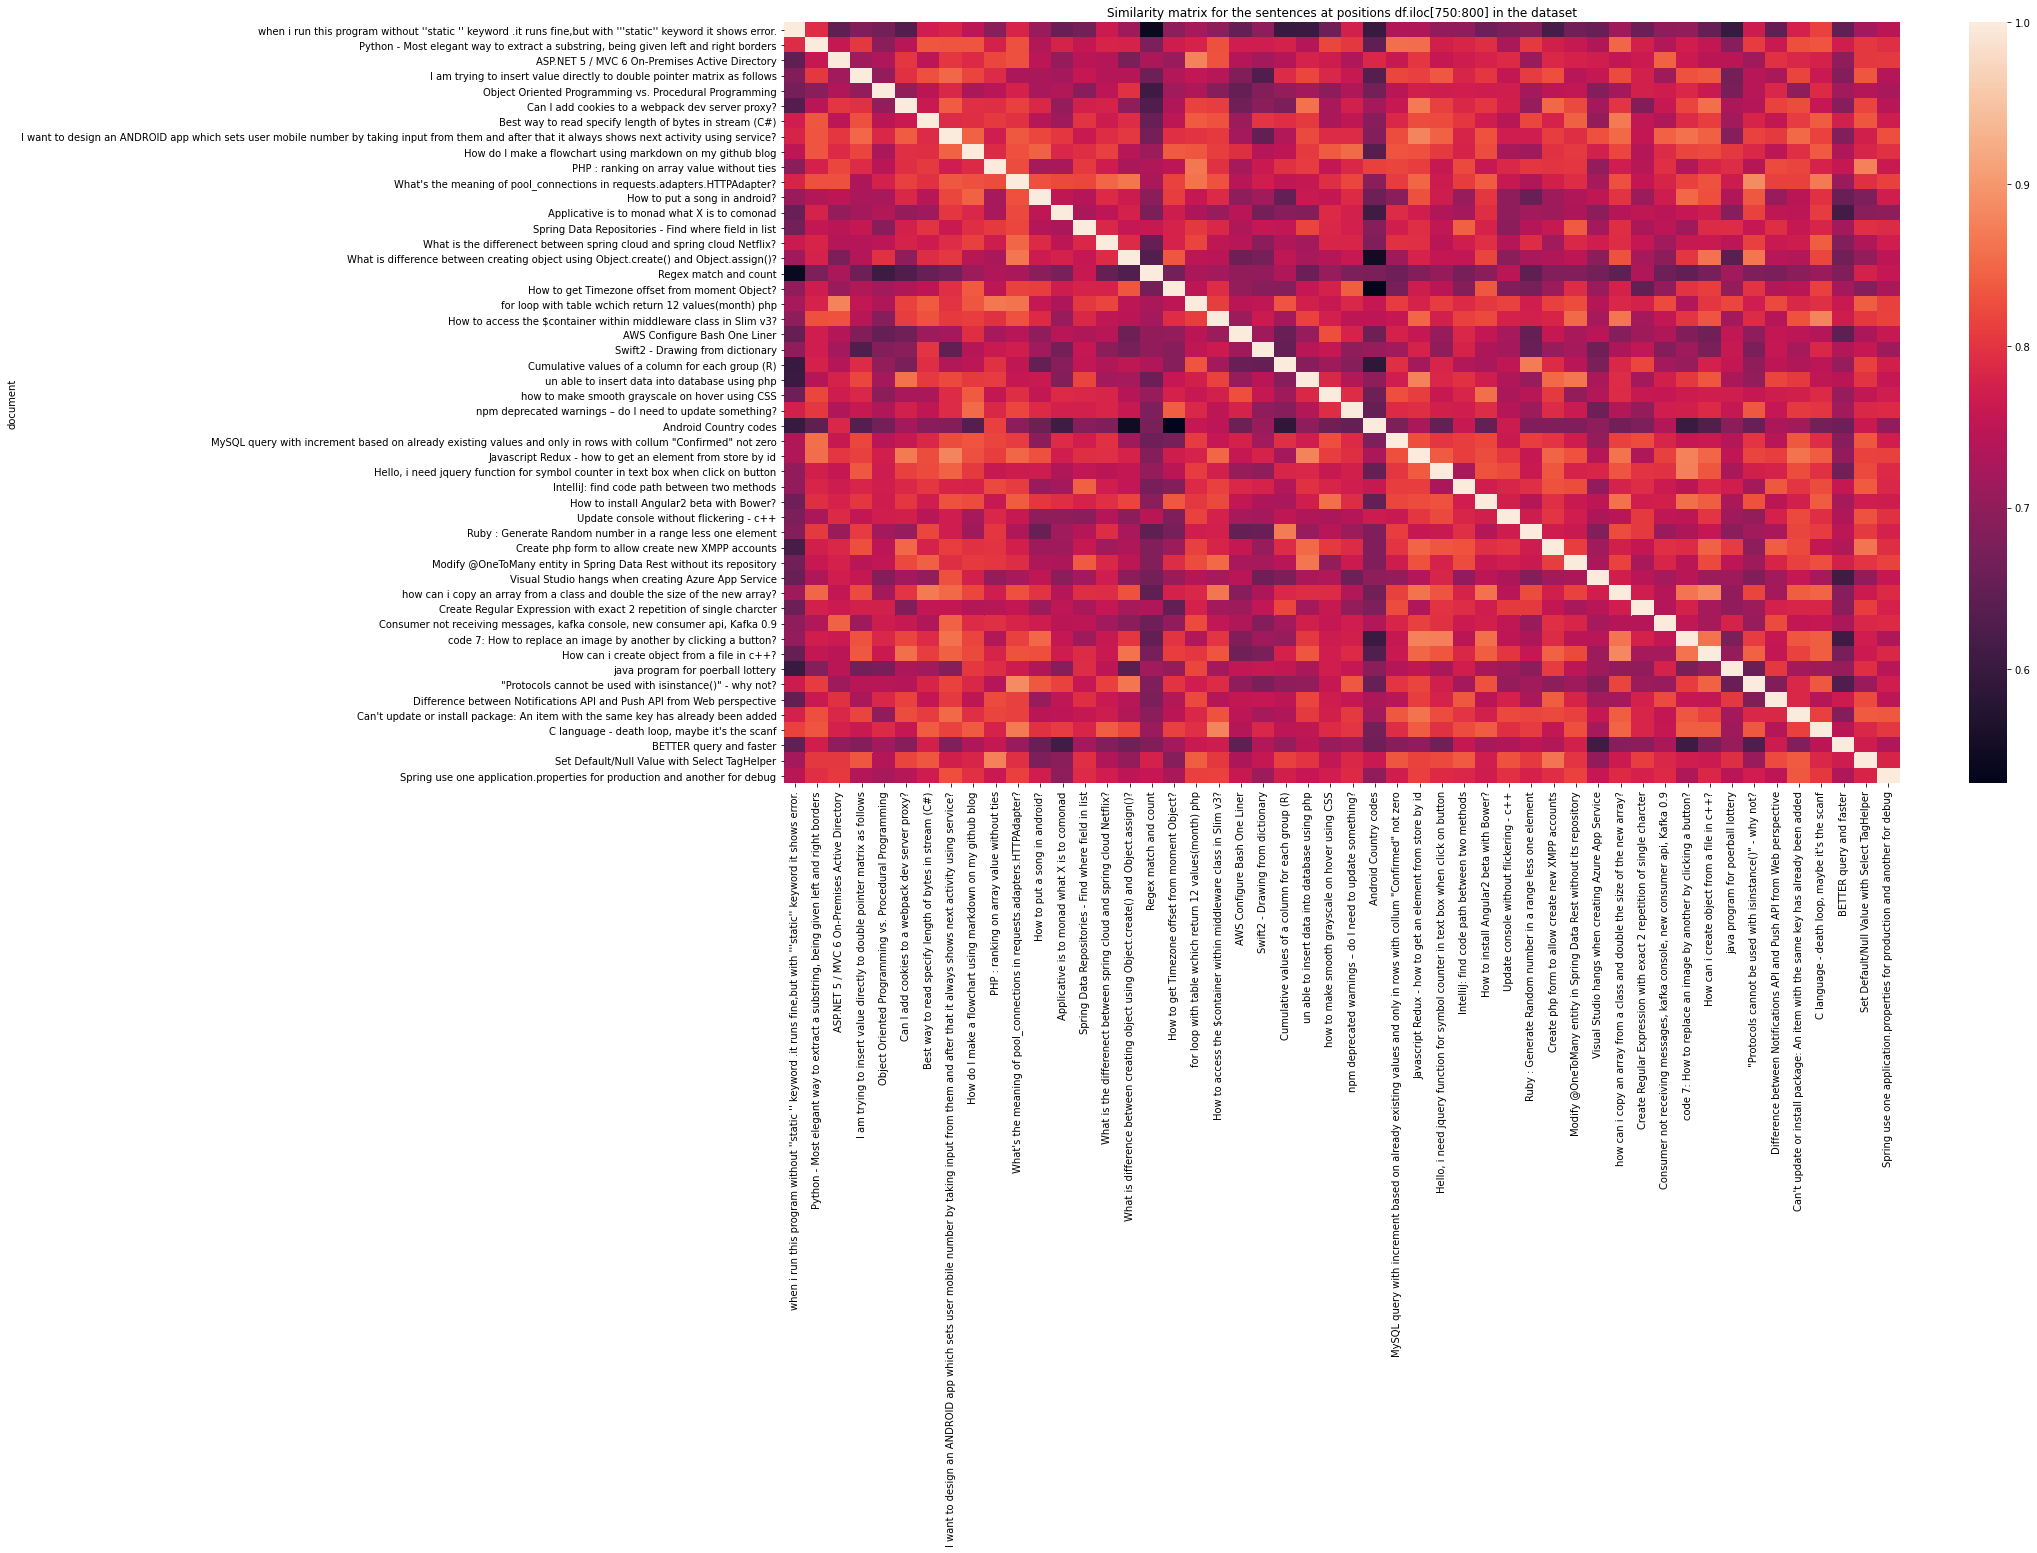

In [ ]:
def viz_sim_matrix_from_to(start_iloc,end_iloc, sim_df = sim_matrix_df):
  # Plot heatmatrix for sentences at df.iloc[start:end]   
  fig, ax = plt.subplots(figsize=(25,14)) 
  sim_df.index = sim_df.document
  sim_columns = list(sim_df.columns)
  for b in non_sim_columns : sim_columns.remove(b)


  ax = sns.heatmap(sim_df.iloc[start_iloc:end_iloc][sim_columns[start_iloc:end_iloc]]) # +2 because first 2 cols are not sim_scores

  ax.axes.set_title(f"Similarity matrix for the sentences at positions df.iloc[{start_iloc}:{end_iloc}] in the dataset",)

viz_sim_matrix_from_to(750,800)

#4.1 Find the N most similar sentences in a datset for a **new sentence** that does not exist in the data using BERT

In [ ]:
def get_sim_df_for_string(predictions,e_col, string_to_embed,pipe=pipe):
  # Creates a Dataframe which has a sim_score column which describes the similarity with the string_to_embed variable

  # put predictions vectors in matrix
  embed_mat = np.array([x for x in predictions[e_col]])

  # embed string input string
  embedding = pipe.predict(string_to_embed).iloc[0][e_col]

  # Replicate embedding for input string 
  m = np.array([embedding,]*len(df))
  sim_mat = cosine_similarity(m,embed_mat)

  #write sim score
  df['sim_score'] = sim_mat[0]


  return df

(0.8, 1.0)

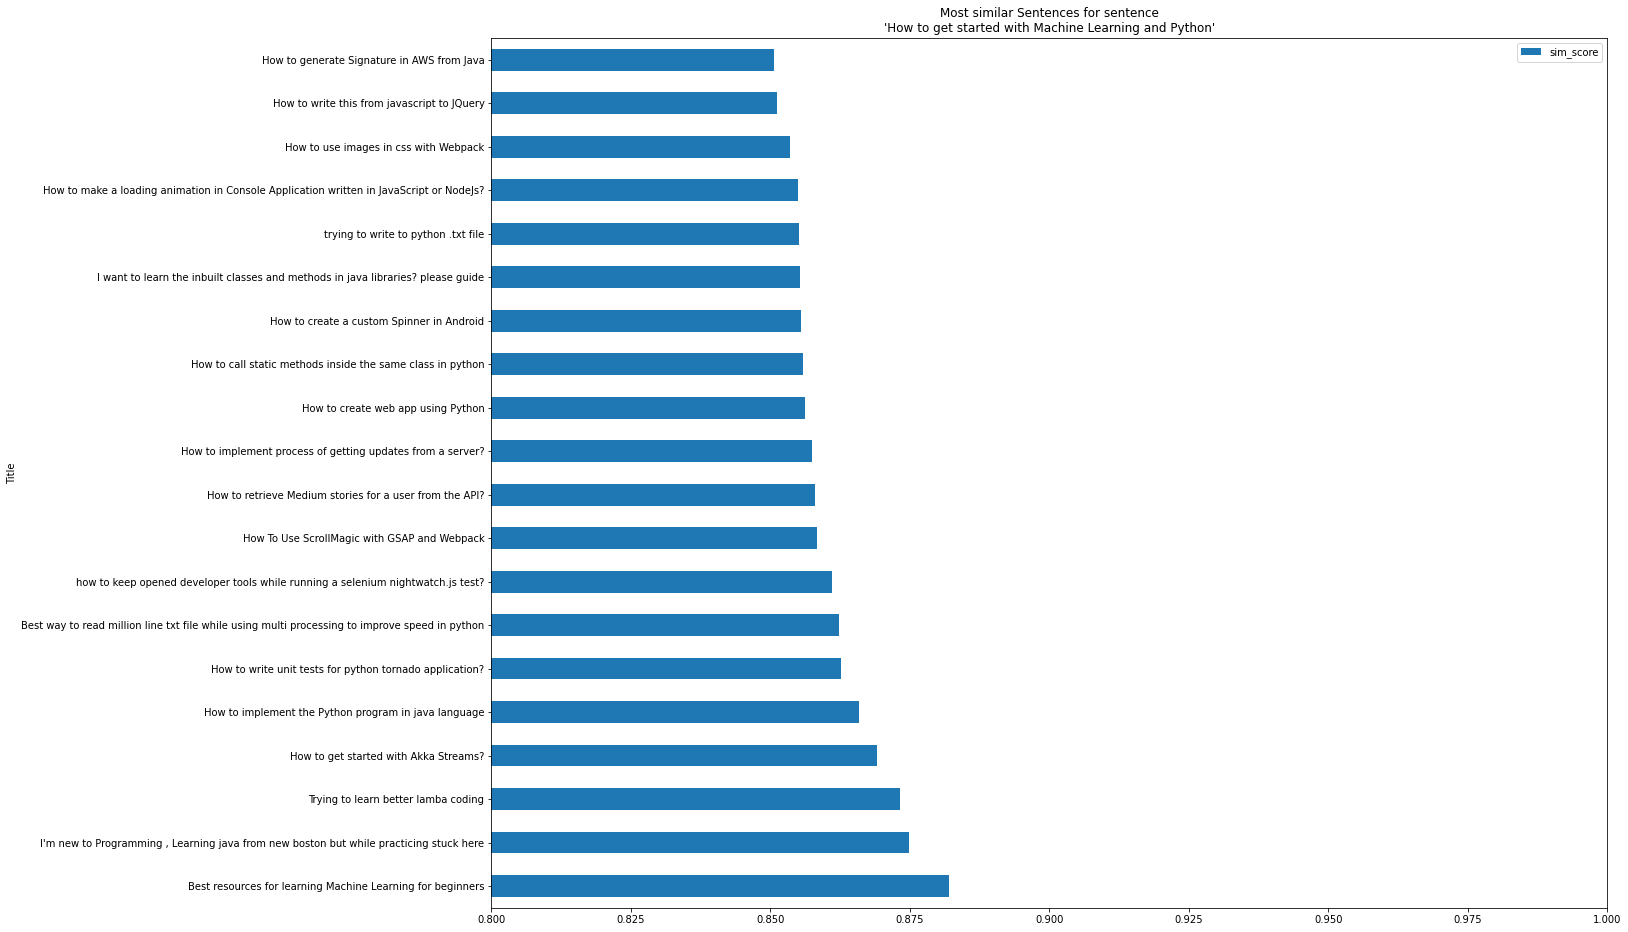

In [ ]:
question = 'How to get started with Machine Learning and Python' 
sim_df = get_sim_df_for_string(predictions,'sentence_embedding_bert', 'How to get started with Machine Learning and Python' )
ax = sim_df.sort_values('sim_score', ascending = False).iloc[:20][['sim_score','Title']].plot.barh(title = f"Most similar Sentences for sentence\n'{question}'", figsize=(20,16))
ax.set_xlim(0.8, 1)


#4.2 Define Helper plotting function to plot results of embedding a string

In [ ]:
def viz_sim_df_for_one_sent( question='How to install linux dualboot', e_col='sentence_embedding_bert', N = 40, sim_df_for_one_sent=sim_df_for_one_sent):
  # Plots the N most similar sentences in our dataframe for sentence at position sent_iloc
  sim_df = get_sim_df_for_string(predictions,e_col,question )
  sim_df.index = sim_df.Title
  sim_df.sort_values('sim_score', ascending = False).iloc[:N][['sim_score','Title']].plot.barh(title = f"Most similar Sentences for sentence\n'{question}'", figsize=(20,14))
  ax.set_xlim(0.8, 1)


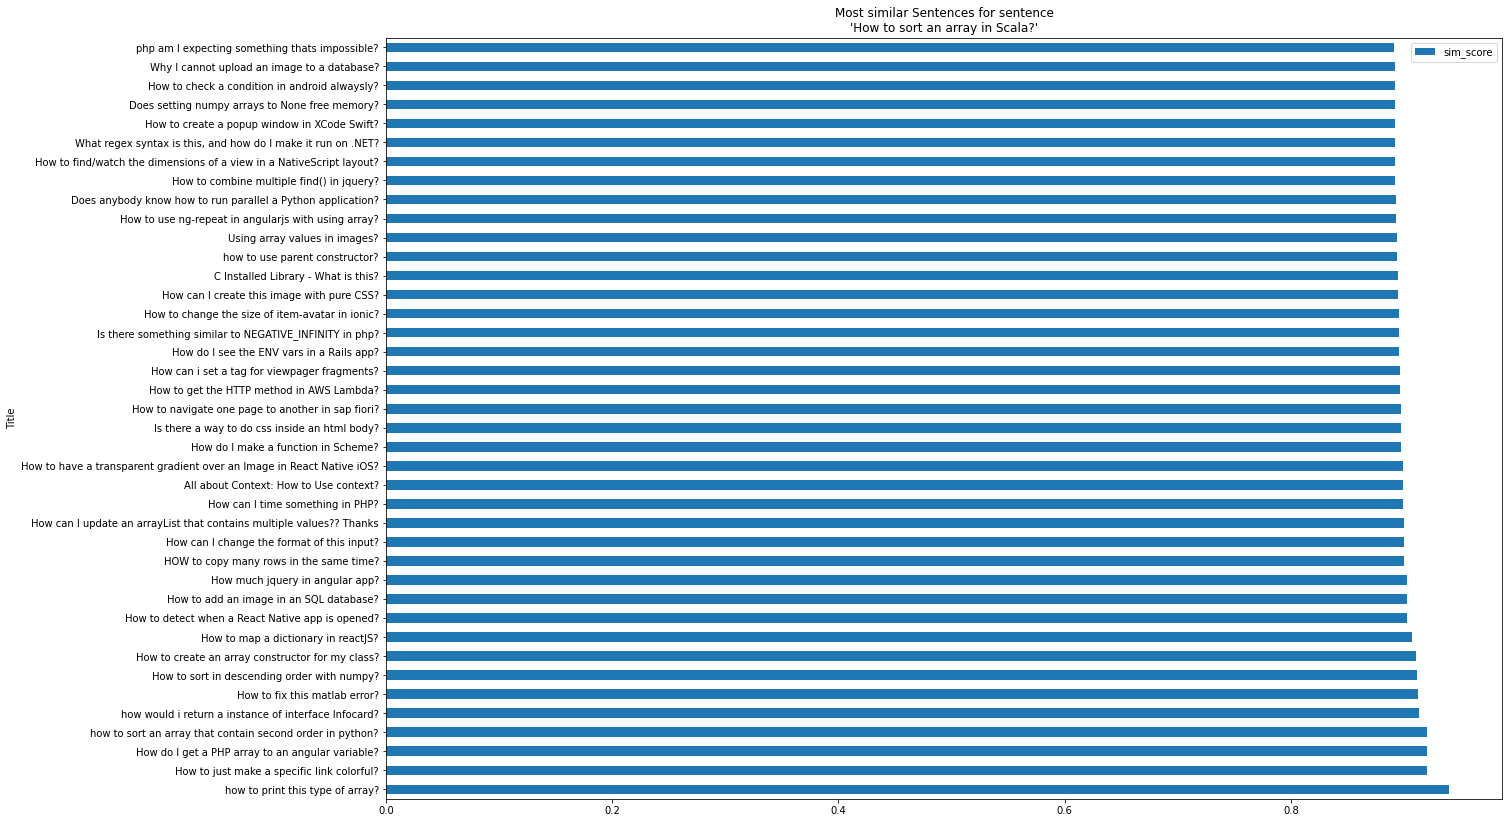

In [ ]:
question = 'How to sort an array in Scala?'
e_col = 'sentence_embedding_bert'
viz_sim_df_for_one_sent(question,e_col)

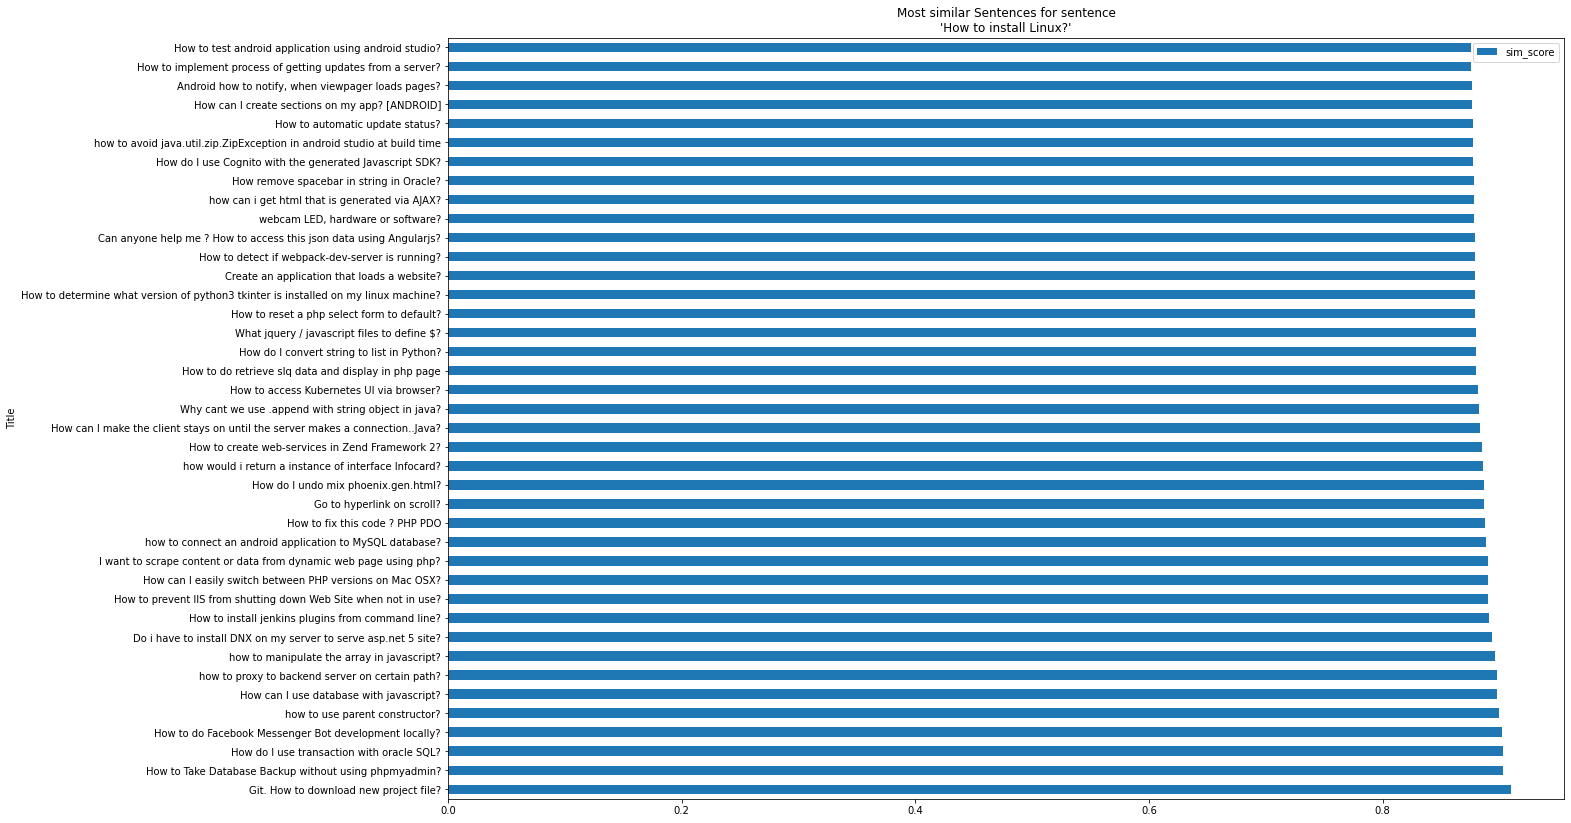

In [ ]:
viz_sim_df_for_one_sent('How to install Linux?')

# 5.1. Multi Embedding Similarity, find the N most similar sentences in a dataset for a new sentence using BERT, USE, Electra

First, let's load 3 embeddings at the same time and embed the text in our dataset

In [ ]:
multi_pipe = nlu.load('use en.embed_sentence.electra embed_sentence.bert')
multi_embeddings = multi_pipe.predict(df.Title,output_level='document')
# multi_embeddings = multi_pipe.predict(df.Title)

multi_embeddings


tfhub_use download started this may take some time.
Approximate size to download 923.7 MB
[OK!]
sent_electra_small_uncased download started this may take some time.
Approximate size to download 48.7 MB
[OK!]
sent_small_bert_L2_128 download started this may take some time.
Approximate size to download 16.1 MB
[OK!]
sentence_detector_dl download started this may take some time.
Approximate size to download 354.6 KB
[OK!]


,document,sentence_embedding_use,sentence_embedding_electra,sentence_embedding_bert
0,Java: Repeat Task Every Random Seconds,"[-0.05815371498465538, 0.016799110919237137, -...","[0.271599680185318, 0.2292635440826416, 0.1583...","[-2.009953498840332, 0.08406741172075272, -0.0..."
1,Why are Java Optionals immutable?,"[-0.00033905860618688166, -0.04124700278043747...","[-0.20169825851917267, -0.15781627595424652, 0...","[-0.9489684700965881, -0.04183836281299591, -0..."
2,Text Overlay Image with Darkened Opacity React...,"[0.02146691083908081, -0.06822465360164642, -0...","[-0.13871802389621735, -0.060319237411022186, ...","[-0.7274762392044067, -0.8136711716651917, -0...."
3,Why ternary operator in swift is so picky?,"[0.04972146451473236, 0.035496875643730164, -0...","[-0.186016246676445, 0.017687972635030746, -0....","[-1.0510447025299072, 0.16469576954841614, -0...."
4,hide/show fab with scale animation,"[-0.0456671379506588, -0.04558160528540611, -0...","[-0.2715802788734436, 0.1265854835510254, 0.05...","[-0.801064133644104, -0.08930190652608871, -0...."
...,...,...,...,...
4995,is it possible to use JavaScriptSpellCheck in ...,"[0.062474653124809265, -0.032156772911548615, ...","[0.03771193325519562, 0.12696674466133118, 0.1...","[-0.28274181485176086, 0.9793228507041931, 0.2..."
4996,"Map<String, Integer> foo - how do I get the va...","[0.017181310802698135, -0.012151309289038181, ...","[-0.1985224038362503, -0.00037411280209198594,...","[-0.7471789121627808, 0.14025633037090302, 0.1..."
4997,Facebook SDK iOS - User photos doesn't retriev...,"[0.056753773242235184, -0.047539979219436646, ...","[-0.201043039560318, -0.10363501310348511, 0.0...","[0.2970831096172333, 0.5095561146736145, -0.35..."
4998,Validate user input using seperate function,"[0.04016668349504471, -0.01402831170707941, -0...","[-0.033403486013412476, 0.3082466423511505, 0....","[-0.9171112775802612, 0.5364910960197449, -0.5..."


#5.2 Multi Embeddings Similarity calculation


Let's define a function that takes in a string to embed, a list of embeddings and a pipeline

get_sim_df_for_string_multi() calculates all embeddings loaded in the input NLU pipeline for the input string and calculate distances to every sentence in the input DF across all embeddings and will give us a final normalized score.     

In [ ]:
def get_sim_df_for_string_multi(predictions,embed_col_names, string_to_embed,pipe=multi_pipe):
  # Creates a Dataframe which has a sim_score column which describes the similarity with the string_to_embed variable
  # This accumulates the distances of all embeddings in embed_col_names and normalizes it by dividing by len(embed_col_names)
  #make empty simmilarity matrix which will store the aggregated simmilarities between different embeddings
  predictions.dropna(inplace=True)
  cum_sim = np.zeros((len(predictions),len(predictions)))

  # embed with all embedders currently loaded in pipeline
  embeddings = pipe.predict(string_to_embed).iloc[0]

  #loop over all embeddings columns and accumulate the pairwise distances with string_to_embed into cum_sim
  for e_col in embed_col_names:
    # get the current embedding for input string
    embedding = embeddings[e_col]  
    # stack embedding vector for input string
    m = np.array([embedding,]*len(predictions)) 
    # put df vectors in np matrix
    embed_mat = np.array([x for x in predictions[e_col]]) 
    # calculate new similarities
    sim_mat = cosine_similarity(m,embed_mat) 
  # accumulate new simmilarities in cum_sum
    cum_sim += sim_mat  

  predictions['sim_score'] = cum_sim[0]/len(embed_col_names) 
  return predictions

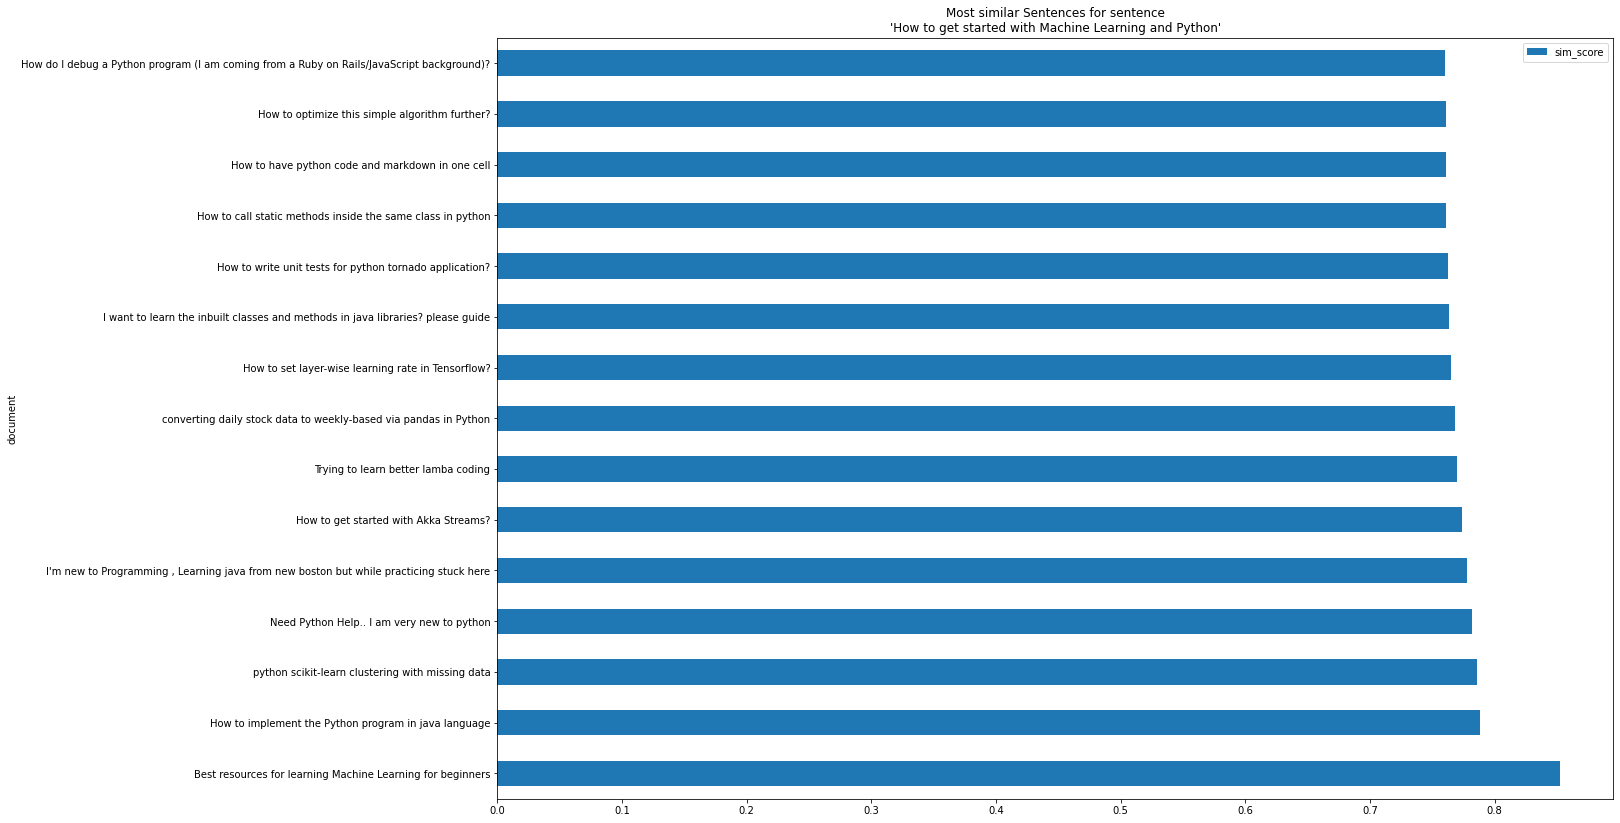

In [ ]:
question = 'How to get started with Machine Learning and Python'
col_names = ['sentence_embedding_use','sentence_embedding_electra', 'sentence_embedding_bert']

sim_df = get_sim_df_for_string_multi(multi_embeddings,col_names, question )
sim_df.index = sim_df.document
sim_df.sort_values('sim_score', ascending = False).iloc[:15][['sim_score','document']].plot.barh(title = f"Most similar Sentences for sentence\n'{question}'", figsize=(20,14))

# 5.3 Define helper function to plot the similarity results of a multi embedded string

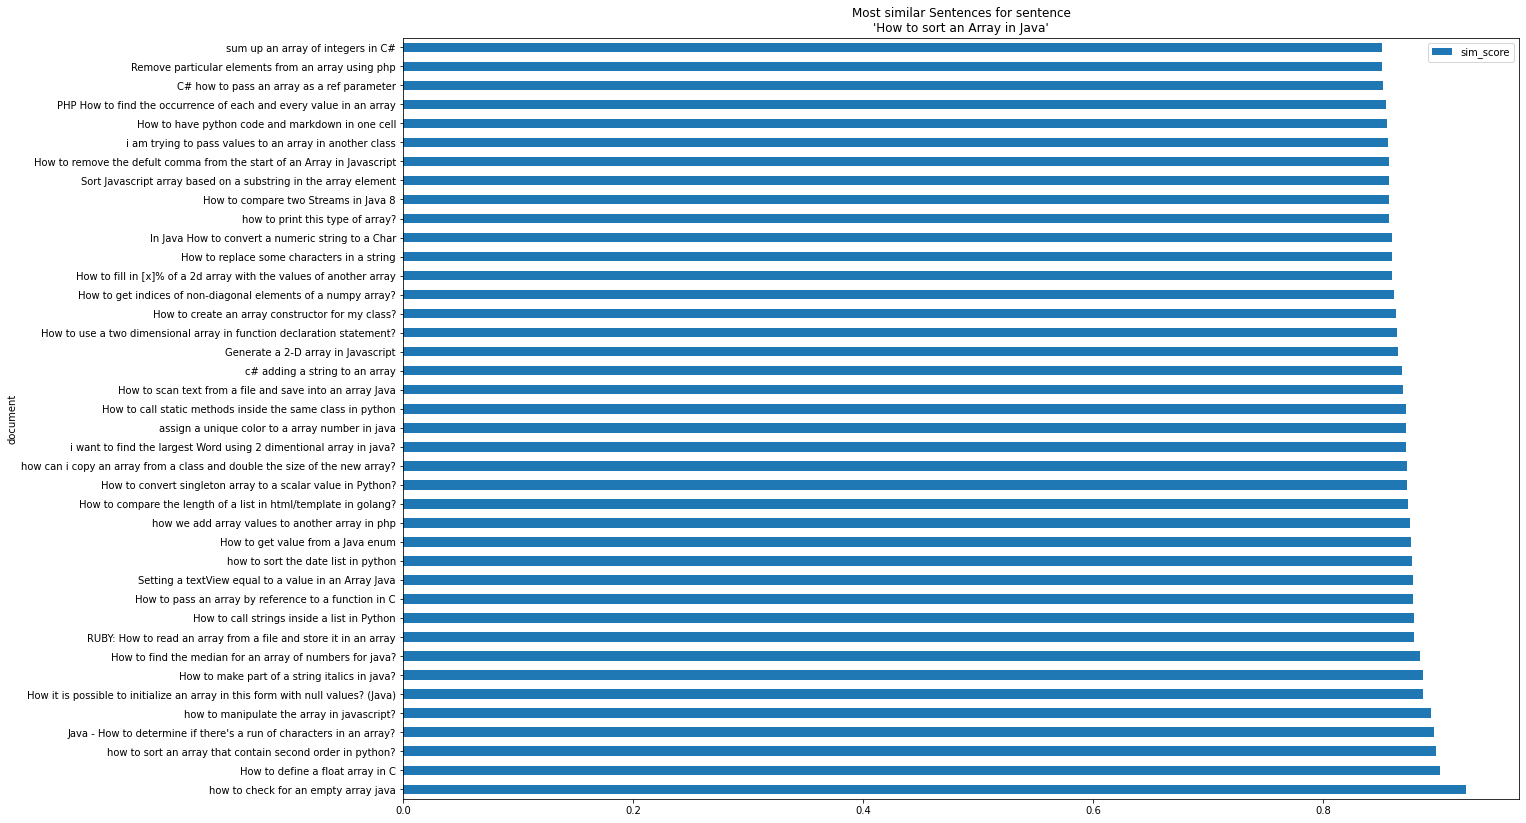

In [ ]:
def viz_sim_df_for_one_sent_multi_embed( question='How to install linux dualboot', e_cols=col_names, N = 40, multi_embeddings=multi_embeddings):
  # Plots the N most similar sentences in our dataframe for sentence at position sent_iloc
  sim_df = get_sim_df_for_string_multi(multi_embeddings,col_names, question )
  sim_df.index = sim_df.document
  sim_df.sort_values('sim_score', ascending = False).iloc[:N][['sim_score','document']].plot.barh(title = f"Most similar Sentences for sentence\n'{question}'",figsize=(20,14))

  ax.set_xlim(0.8, 1)

question = 'How to sort an Array in Java'
col_names = ['sentence_embedding_use','sentence_embedding_electra', 'sentence_embedding_bert']
viz_sim_df_for_one_sent_multi_embed(question, col_names)

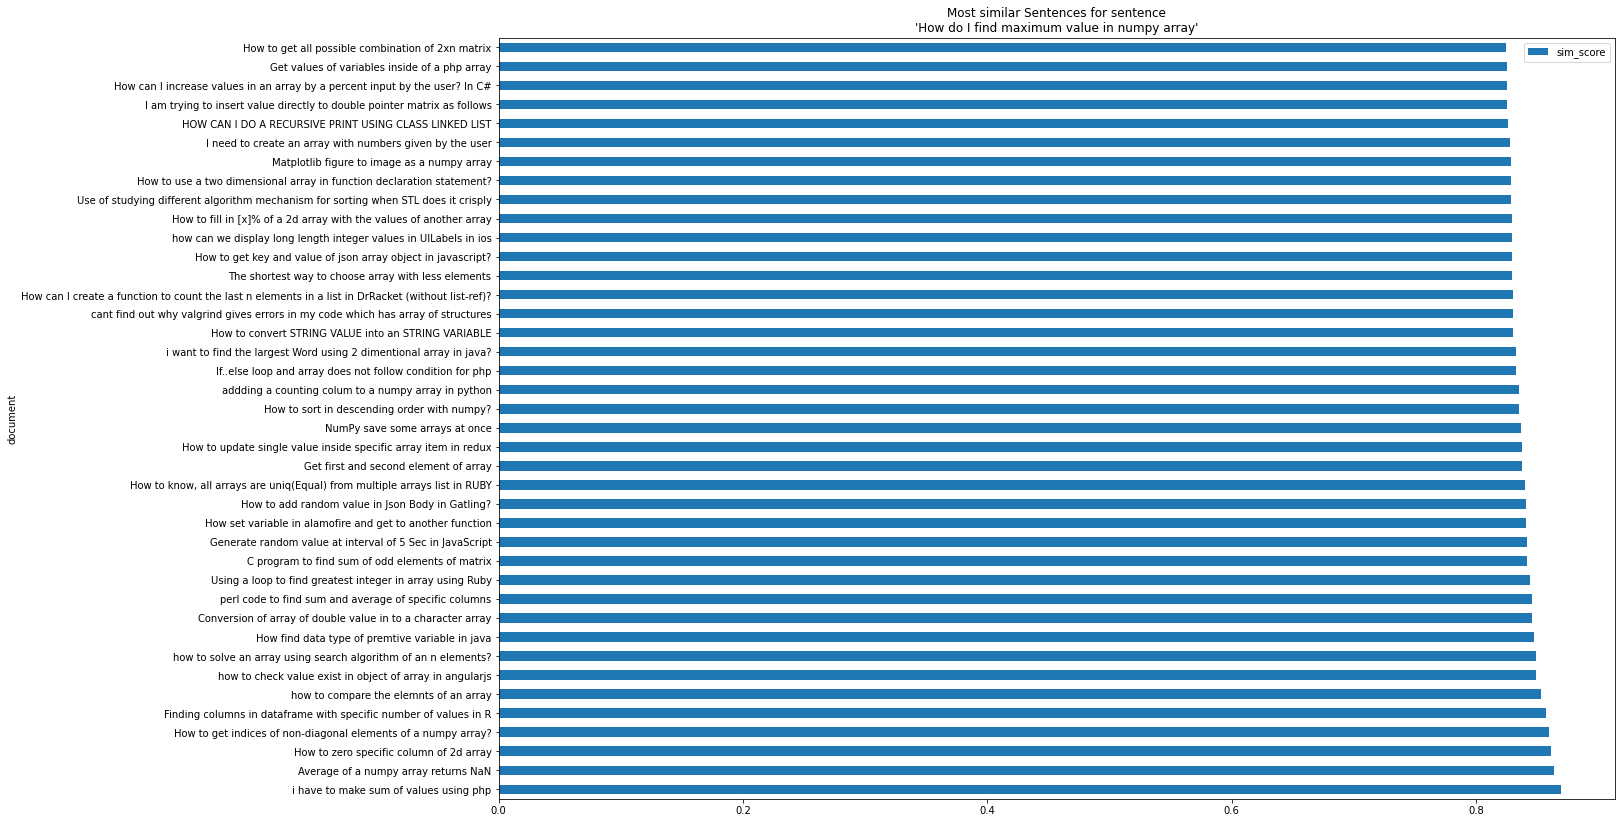

In [ ]:
question = 'How do I find maximum value in numpy array'
viz_sim_df_for_one_sent_multi_embed(question)

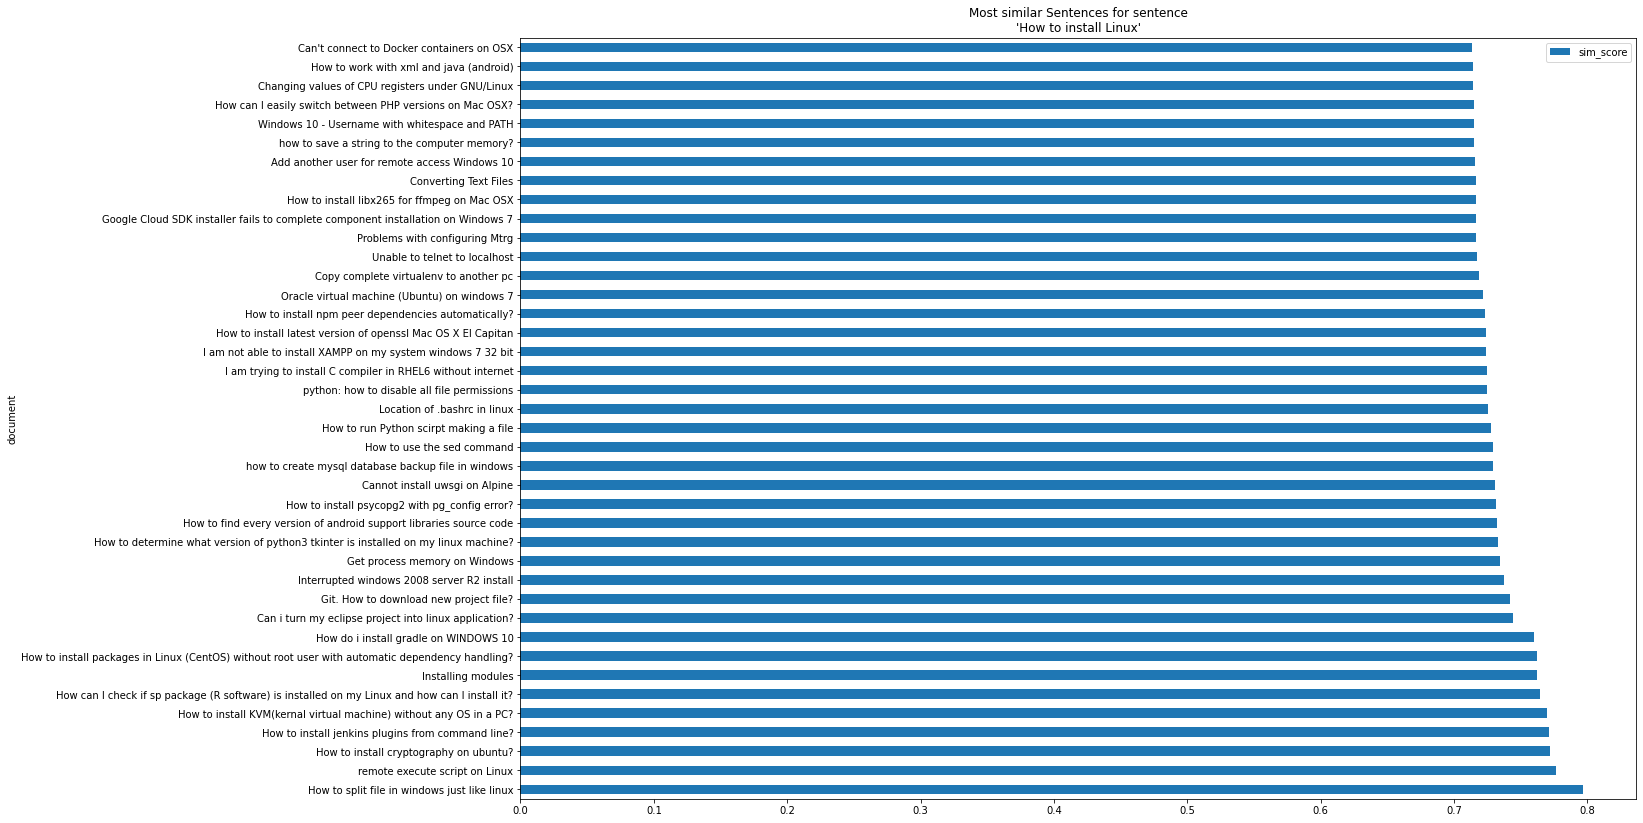

In [ ]:
question = 'How to install Linux'
viz_sim_df_for_one_sent_multi_embed(question)

# 6. There are many more Sentence Embeddings to try out!
Even multi lingual embeddings like nlu.load('xx.embed_sentence.labse')

In [ ]:
nlu.print_all_model_kinds_for_action('embed_sentence')

For language <en> NLU provides the following Models : 
nlu.load('en.embed_sentence') returns Spark NLP model tfhub_use
nlu.load('en.embed_sentence.use') returns Spark NLP model tfhub_use
nlu.load('en.embed_sentence.tfhub_use') returns Spark NLP model tfhub_use
nlu.load('en.embed_sentence.use.lg') returns Spark NLP model tfhub_use_lg
nlu.load('en.embed_sentence.tfhub_use.lg') returns Spark NLP model tfhub_use_lg
nlu.load('en.embed_sentence.albert') returns Spark NLP model albert_base_uncased
nlu.load('en.embed_sentence.electra') returns Spark NLP model sent_electra_small_uncased
nlu.load('en.embed_sentence.electra_small_uncased') returns Spark NLP model sent_electra_small_uncased
nlu.load('en.embed_sentence.electra_base_uncased') returns Spark NLP model sent_electra_base_uncased
nlu.load('en.embed_sentence.electra_large_uncased') returns Spark NLP model sent_electra_large_uncased
nlu.load('en.embed_sentence.bert') returns Spark NLP model sent_bert_base_uncased
nlu.load('en.embed_sentenc